In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn

sbn.set(font_scale=1.5)
sbn.set_style('white')

%matplotlib inline

# Visualization

This script visualizes the data produced by the previous two scripts. This includes a summary table examining the gRNAs grouped by region as well as determining the number of Broad Spectrum gRNAs. Next, the cleavage results are visualized across the HXB2 genome as well as plotted against the entropy of the region. Finally, a heatmap is created to vizualize why certain gRNAs are likely ineffective against patient samples.

In [2]:
data = pd.read_excel('results/SupTable1.xlsx')
res = pd.read_excel('results/FrequencyTables/26607397_LTR-2.xlsx')
data.head()

,Citation,Name,Start,Stop,gRNA,Percent cleaved,Entropy (bits),Number of Sequences Evaluated,Region,MIT Score,AS50
0,23974631,T5,465,484,GTTAGACCAGATCTGAGCCT.NGG,68.274303,2.615312,1327,LTR,67.0,0.000000
1,23974631,T6,343,362,GCTACAAGGGACTTTCCGCT.NGG,84.306293,2.959877,1319,LTR,NaN,0.000000
2,25049410,LTR-A,98,127,AGGGCCAGGGATCAGATATCCACTGACCTT.NGG,55.044700,5.249049,783,LTR,NaN,0.000000
3,25049410,LTR-B,312,341,CCN.GAGTACTTCAAGAACTGCTGACATCGAGCT,21.412639,4.605056,1345,LTR,NaN,0.364521
4,25049410,LTR-C,78,97,GATTGGCAGAACTACACACC.NGG,70.325203,2.660178,492,LTR,81.0,0.000000


In [3]:
# Here we're defining Broad Spectrum as those which cleave 50% of sequences

data['EF50'] = data['Percent cleaved'] >= 50
data['EF90'] = data['Percent cleaved'] >= 90
rdict = {'Gag': 'Gag/Pol', 'Pol': 'Gag/Pol'}
sum_table = data.replace(rdict).groupby('Region').agg({'gRNA': 'count', 
                                                       'EF50':'sum',
                                                       'EF90':'sum'}).astype(int)
sum_table

,EF90,gRNA,EF50
Region,,,
Env,2,14,5
Gag/Pol,0,57,32
LTR,2,148,89
Nef,0,1,1
Rev/Env,0,3,3
Tat,0,1,0
Tat/Rev,0,2,2
Vif,0,2,0
Vpr,0,1,0


In [4]:
sum_table[['gRNA', 'EF50', 'EF90']].to_excel('results/Table1.xlsx')

In [5]:
import FigureTools
reload(FigureTools)

<module 'FigureTools' from 'FigureTools.pyc'>

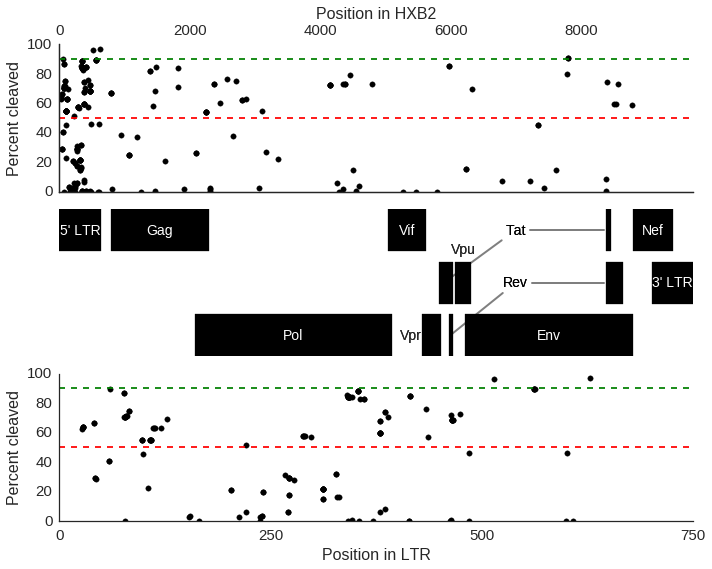

In [6]:
fig, (hxb2_ax, orf_ax, ltr_ax) = plt.subplots(3, 1, figsize=(10, 8))

FigureTools.generate_genome_plot(hxb2_ax, data, top_axis=True)
hxb2_ax.hlines(50, 0, 9717, linestyle = '--', color = 'r')
hxb2_ax.hlines(90, 0, 9717, linestyle = '--', color = 'g')

ltr_ax.hlines(50, 0, 750, linestyle = '--', color = 'r')
ltr_ax.hlines(90, 0, 750, linestyle = '--', color = 'g')
FigureTools.generate_genome_plot(ltr_ax, data, xlims=(0, 700))
ltr_ax.set_xticks([0, 250, 500, 750])

ltr_ax.set_xlabel('Position in LTR')

FigureTools.generate_hiv_orfs(orf_ax)

fig.tight_layout()
fig.savefig('results/Fig1AB.png', dpi=300)

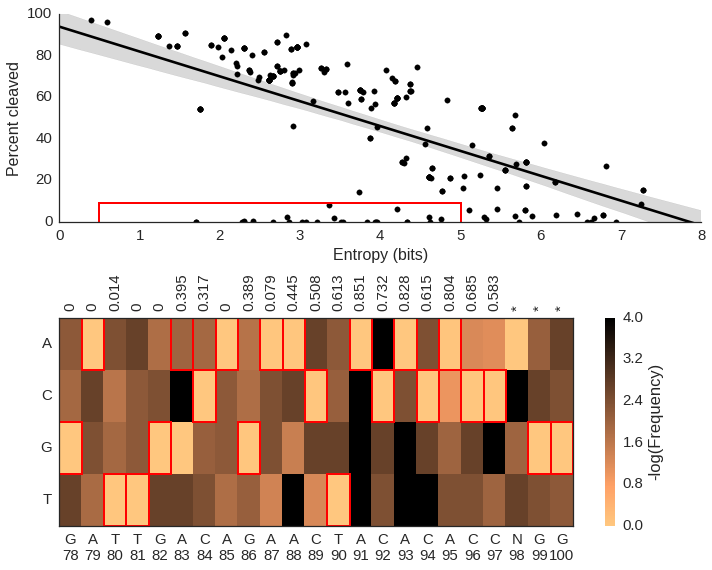

In [7]:
fig, (ent_ax, heat_ax) = plt.subplots(2, 1, figsize=(10, 8))

FigureTools.generate_entropy_plot(ent_ax, data)
FigureTools.generate_heatmap(heat_ax, res.clip_lower(1.0/10000), 'GATTGACAGAACTACACACCNGG', 78,
                             vmin=0, vmax=4)

fig.tight_layout()
fig.savefig('results/Fig2AB.png', dpi=300)

In [8]:
from itertools import islice
import os

def freq_path(citation, name, base_dir = 'results/FrequencyTables/'):
    
    fname = '%i_%s.xlsx' % (citation, name.strip())
    return os.path.join(base_dir, fname.replace(' ', '-'))

# Produce the frequency heatmap for all gRNAs

for _, row in data.iterrows():
    
    path = freq_path(row['Citation'], row['Name'])
    freqs = pd.read_excel(path)

    fig, ax = plt.subplots(1, 1, figsize=(12, 5))
    for_strand = row['gRNA'].endswith('.NGG')
    
    # Deal with orientation and length issues
    if for_strand:
        target = row['gRNA'].replace('.', '')[-23:]
    else:
        target = row['gRNA'].replace('.', '')[:23]
        
    FigureTools.generate_heatmap(ax, freqs.clip_lower(1.0/10000), 
                                 target, row['Start'], for_strand=for_strand)
    
    ax.set_ylabel(row['Name'] + ' %i' % row['Percent cleaved'] + '% cleaved')
    
    fig.tight_layout()
    fig.savefig(path.replace('.xlsx', '.png'))
    plt.close()
    

In [9]:
cutoff_data = pd.read_excel('results/summary_res_all_gRNAs.xlsx')
cutoff_data.head()

,Region,Citation,Name,Start,Stop,gRNA,Cutoff,ProtoMean,ProtoCut,HasPam,ProtoPamMean,ProtoPamCut,Entropy,NumSeqs
0,LTR,23974631,T5,465,484,GTTAGACCAGATCTGAGCCT.NGG,0.00,0.77627,1.000000,0.963828,0.769499,0.963828,2.615312,1327
1,LTR,23974631,T5,465,484,GTTAGACCAGATCTGAGCCT.NGG,0.05,0.77627,0.978146,0.963828,0.769499,0.963075,2.615312,1327
2,LTR,23974631,T5,465,484,GTTAGACCAGATCTGAGCCT.NGG,0.10,0.77627,0.963828,0.963828,0.769499,0.951771,2.615312,1327
3,LTR,23974631,T5,465,484,GTTAGACCAGATCTGAGCCT.NGG,0.15,0.77627,0.876413,0.963828,0.769499,0.870384,2.615312,1327
4,LTR,23974631,T5,465,484,GTTAGACCAGATCTGAGCCT.NGG,0.20,0.77627,0.874906,0.963828,0.769499,0.868877,2.615312,1327


In [10]:
pdf = pd.pivot_table(cutoff_data.query('Cutoff < 1'),
                     index = ['Citation', 'Name'],
                     columns = 'Cutoff',
                     values = 'ProtoPamCut')
pdf.head()

Cutoff              0.00      0.05      0.10      0.15      0.20      0.25  \
Citation Name                                                                
23974631 T5     0.963828  0.963075  0.951771  0.870384  0.868877  0.865863   
         T6     0.976497  0.976497  0.968916  0.966641  0.935557  0.934799   
25049410 LTR-A  0.947637  0.855683  0.828863  0.814815  0.796935  0.789272   
         LTR-B  0.896654  0.879554  0.827509  0.812639  0.793309  0.610409   
         LTR-C  0.983740  0.983740  0.961382  0.908537  0.804878  0.802846   

Cutoff              0.30      0.35      0.40      0.45      0.50      0.55  \
Citation Name                                                                
23974631 T5     0.861341  0.860588  0.733986  0.691786  0.691032  0.691032   
         T6     0.932525  0.896133  0.890826  0.874147  0.872631  0.871114   
25049410 LTR-A  0.771392  0.758621  0.720307  0.719029  0.623244  0.623244   
         LTR-B  0.608922  0.608178  0.235688  0.235688  0.226022  0.226022   
         LTR-C  0.800813  0.796748  0.796748  0.788618  0.752033  0.723577   

Cutoff              0.60      0.65      0.70      0.75      0.80      0.85  \
Citation Name                                                                
23974631 T5     0.691032  0.685004  0.682743  0.682743  0.682743  0.682743   
         T6     0.871114  0.863533  0.843063  0.843063  0.843063  0.843063   
25049410 LTR-A  0.621967  0.551724  0.550447  0.550447  0.550447  0.550447   
         LTR-B  0.225279  0.214126  0.214126  0.214126  0.214126  0.214126   
         LTR-C  0.723577  0.703252  0.703252  0.703252  0.703252  0.703252   

Cutoff              0.90      0.95  
Citation Name                       
23974631 T5     0.682743  0.676714  
         T6     0.843063  0.842305  
25049410 LTR-A  0.550447  0.549170  
         LTR-B  0.214126  0.214126  
         LTR-C  0.703252  0.703252

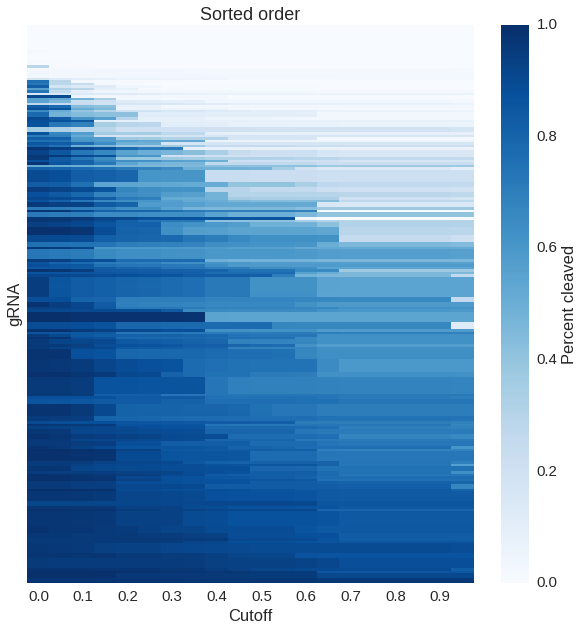

In [11]:
fig, ax = plt.subplots(1,1, figsize=(10, 10))

inds = pdf.sum(axis=1).sort_values()
spdf = pdf.ix[inds.index]


sbn.heatmap(spdf, yticklabels=False, vmin=0, vmax=1, ax=ax,
            cmap='Blues',
            cbar_kws={'label': 'Percent cleaved'})

labels = ax.get_xticklabels()[::2]
ax.set_xticks(ax.get_xticks()[::2])
ax.set_xticklabels(labels);
ax.set_ylabel('gRNA')
ax.set_title('Sorted order')
fig.savefig('results/SupFig1.png', dpi=300)

In [12]:
pub_dates = {23974631: '9/26/2013', 
             25049410: '9/5/2014', 
             25752527: '1/27/2015', 
             25808449: '2/27/2015', # Lang
             26538064: '11/5/2015', 
             26581162: '3/24/2016',
             26607397: '1/5/2016', 
             26775808: '2/16/2016', 
             26796669: '2/16/2016', # Berkout
             26939770: '3/4/2016', 
             26990633: '5/15/2017', 
             27068471: '4/7/2016', # Lang
             27194423: '9/1/2016',
             27278725: '7/13/2016', 
             27341108: '6/13/2016', 
             27404981: '6/16/2016', 
             27528385: '6/20/2016', 
             27974196: '12/13/2016', 
             28176813: '12/30/2016',
             25781496: '3/17/2015', 
             26035832: '6/2/2015', 
             27698388: '10/4/2016', 
             28366764: '5/3/2017', 
             28670581: '1/12/2017', 
             28729655: '6/20/2017'}

cutoff_data['PubDate'] = pd.to_datetime(cutoff_data['Citation'].replace(pub_dates))
cutoff_data['MonthSinceFirst'] = (cutoff_data['PubDate'] - pd.to_datetime('9/26/2013'))/np.timedelta64(30, 'D')
cutoff_data.head()



,Region,Citation,Name,Start,Stop,gRNA,Cutoff,ProtoMean,ProtoCut,HasPam,ProtoPamMean,ProtoPamCut,Entropy,NumSeqs,PubDate,MonthSinceFirst
0,LTR,23974631,T5,465,484,GTTAGACCAGATCTGAGCCT.NGG,0.00,0.77627,1.000000,0.963828,0.769499,0.963828,2.615312,1327,2013-09-26,0.0
1,LTR,23974631,T5,465,484,GTTAGACCAGATCTGAGCCT.NGG,0.05,0.77627,0.978146,0.963828,0.769499,0.963075,2.615312,1327,2013-09-26,0.0
2,LTR,23974631,T5,465,484,GTTAGACCAGATCTGAGCCT.NGG,0.10,0.77627,0.963828,0.963828,0.769499,0.951771,2.615312,1327,2013-09-26,0.0
3,LTR,23974631,T5,465,484,GTTAGACCAGATCTGAGCCT.NGG,0.15,0.77627,0.876413,0.963828,0.769499,0.870384,2.615312,1327,2013-09-26,0.0
4,LTR,23974631,T5,465,484,GTTAGACCAGATCTGAGCCT.NGG,0.20,0.77627,0.874906,0.963828,0.769499,0.868877,2.615312,1327,2013-09-26,0.0


Entropy 0.148787842762
cutting 0.214160932978


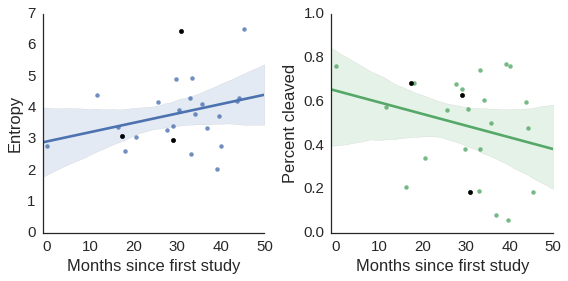

In [13]:
from scipy.stats import linregress

fig, (ent_ax, cut_ax) = plt.subplots(1,2, figsize=(8,4))

wanted_cut = cutoff_data.query('Cutoff == 0.75')
med_data = wanted_cut.groupby('Citation').median()

sbn.regplot(data = med_data,
            x = 'MonthSinceFirst',
            y = 'Entropy', ax=ent_ax)
ent_ax.set_xlim(-1, None)
tup = linregress(med_data['MonthSinceFirst'], med_data['Entropy'])
#ent_ax.set_title('p=%05f' % tup.pvalue)
print 'Entropy', tup.pvalue

wanted_cits = [25808449, 26796669, 27068471]

ent_ax.scatter(med_data.ix[wanted_cits]['MonthSinceFirst'], 
               med_data.ix[wanted_cits]['Entropy'], color='k')
ent_ax.set_xlabel('Months since first study')



sbn.regplot(data = med_data,
            x = 'MonthSinceFirst',
            y = 'ProtoPamCut', ax=cut_ax)
cut_ax.set_xlim(-1, None)
cut_ax.set_ylim(0, 1)
cut_ax.set_ylabel('Percent cleaved')

cut_ax.scatter(med_data.ix[wanted_cits]['MonthSinceFirst'], 
               med_data.ix[wanted_cits]['ProtoPamCut'], color='k')



tup = linregress(med_data['MonthSinceFirst'], med_data['ProtoPamCut'])
print 'cutting', tup.pvalue
#cut_ax.set_title('p=%05f' % tup.pvalue)
cut_ax.set_xlabel('Months since first study')

sbn.despine(ax=ent_ax)
sbn.despine(ax=cut_ax)

fig.tight_layout()
fig.savefig('results/response_review.png', dpi=300)